In [1]:

import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.image as mpimg


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
df = pd.DataFrame(pd.read_json("https://api.apispreadsheets.com/api/dataset/congressional-voting/",
                    orient = 'split'))
def encode(x):
    if x == "n":
        return -1
    if x == "?":
        return 0
    if x == "y":
        return 1
    if x == "republican":
        return -1
    if x == "democrat":
        return 1
    
df = df.drop_duplicates()
df = df.applymap( encode)

In [3]:
X = pd.DataFrame( df)
y = pd.DataFrame( X["political_party"])
X.drop( columns = ["political_party"], inplace=True )


In [4]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, stratify = y, test_size=0.2, random_state=1)
    
X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, stratify = y_train, test_size=0.25, random_state=1)

### Baseline na podstawie physician_fee_freeze

In [5]:
def encode_base(x):
    if x==-1:
        return 1
    if x== 1:
        return -1
    if x == 0:
        return 0

In [6]:
print( 'Accuracy val: %.3f' % accuracy_score( y_val, X_val["physician_fee_freeze"].map( encode_base )))
print( 'Accuracy test: %.3f' % accuracy_score( y_test, X_test["physician_fee_freeze"].map( encode_base )))

Accuracy val: 0.855
Accuracy test: 0.957


### Adaboost

In [7]:
alf = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.9) # dobrze działające parametry
alf.fit(X_train, y_train)

/home/kurowskik/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(learning_rate=0.9, n_estimators=100, random_state=0)

In [8]:
y_val_hat = alf.predict(X_val)
y_test_hat = alf.predict(X_test)

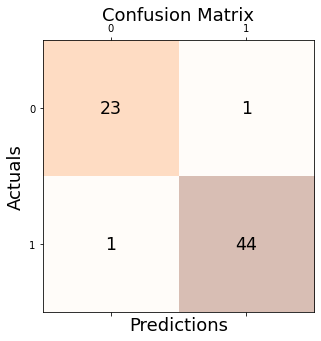

In [9]:
conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_val_hat.round())
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [10]:
print('F1 Score: %.3f' % f1_score(y_test, y_test_hat))
print('F1 Score: %.3f' % f1_score(y_val, y_val_hat))
print('Accuracy val: %.3f' % accuracy_score(y_val, y_val_hat))
print('Accuracy test: %.3f' % accuracy_score(y_test, y_test_hat))

F1 Score: 0.966
F1 Score: 0.978
Accuracy val: 0.971
Accuracy test: 0.957


### GradBoost

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
clf = GradientBoostingClassifier(n_estimators=90, learning_rate=0.8,
      max_depth=1, random_state=0).fit(X_train, y_train) # dobrze działające parametry
clf.score(X_test, y_test)

/home/kurowskik/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9565217391304348

In [13]:
y_val_hat = clf.predict(X_val)
y_test_hat = clf.predict(X_test)

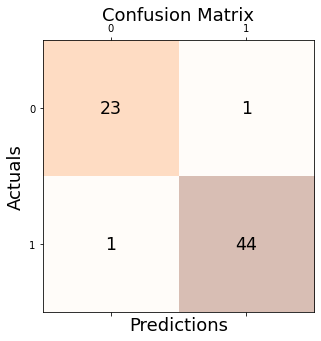

In [14]:
conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_val_hat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [15]:
print('F1 Score val : %.3f' % f1_score(y_val, y_val_hat))
print('F1 Score test: %.3f' % f1_score(y_test, y_test_hat))
print('Accuracy val: %.3f' % accuracy_score(y_val, y_val_hat))
print('Accuracy test: %.3f' % accuracy_score(y_test, y_test_hat))

F1 Score val : 0.978
F1 Score test: 0.966
Accuracy val: 0.971
Accuracy test: 0.957


### HistGradBoost

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor

In [17]:
est = HistGradientBoostingRegressor( l2_regularization= 2, learning_rate=0.7).fit(X_train, y_train)
est.score(X_val, y_val)

/home/kurowskik/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5986765808634488

In [18]:
y_val_hat = est.predict(X_val).round()
y_test_hat = est.predict(X_test).round()

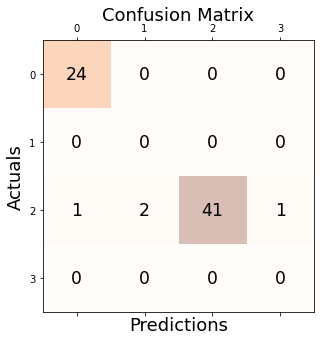

In [19]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=np.int64(y_test_hat))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [20]:
print( accuracy_score(y_val, y_val_hat))
print( accuracy_score(y_test, y_test_hat))

0.8695652173913043
0.9420289855072463


### Test na danych tylko z dobrym rozdzielaniem
Sprawdziliśmy jak się zachowują wyniki, gdy wybieramy tylko te głosowania, które dobrze rozdzielają partie.

In [21]:
X2 = pd.DataFrame( X[ ["crime", "el_salvador_aid", "education_spending", "physician_fee_freeze", "adoption_of_the_budget_resolution"]])

In [22]:
X_train2, X_test2, y_train2, y_test2 \
    = train_test_split(X2, y, stratify = y, test_size=0.2, random_state=1)
    
X_train2, X_val2, y_train2, y_val2 \
    = train_test_split(X_train2, y_train2, stratify = y_train2, test_size=0.25, random_state=1)

In [23]:
alf2 = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.9)
alf2.fit(X_train2, y_train2)

/home/kurowskik/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(learning_rate=0.9, n_estimators=100, random_state=0)

In [24]:
y_val_hat2 = alf2.predict(X_val2)
y_test_hat2 = alf2.predict(X_test2)

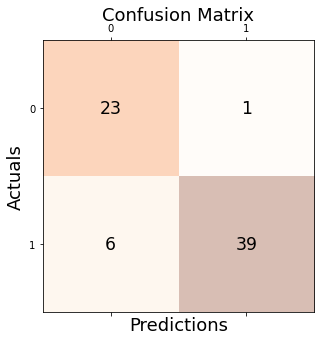

In [25]:
conf_matrix = confusion_matrix(y_true=y_val2, y_pred=y_val_hat2.round())
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [26]:
print( accuracy_score(y_val2, y_val_hat2))
print( accuracy_score(y_test2, y_test_hat2))

0.8985507246376812
0.9565217391304348


wyniki są nieco gorsze od Ada czy Grad, ale wciąż nieco lepsze od Baseline'u.

### Usuwanie danych

Sprawdziliśmy, czy przy usunięciu słabo rozdzielających głosowań i 'outlierowych' kongresmenów uzyskamy lepsze rezultaty - okazało się, że nie.

In [27]:
X_count = np.apply_along_axis(sum, 1, abs(X))
indexes = df[X_count < 11].index
indexes = np.array(indexes)
print(df.shape)
X_dropped = df.drop(indexes, axis=0)

print(X_dropped.shape)

(342, 17)
(333, 17)


In [28]:
col_ls = ['water_project_cost_sharing', 'immigration', 'export_administration_act_south_africa', ]
X_dropped = X_dropped.drop(col_ls, axis=1, errors='ignore')
print(X_dropped.shape)

(333, 14)


In [29]:
y_dropped = X_dropped[['political_party']]
X_dropped.drop(['political_party'], axis=1, errors='ignore', inplace=True)


In [30]:
X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test \
    = train_test_split(X_dropped, y_dropped, stratify = y_dropped, test_size=0.2, random_state=1)
    
X_dropped_train, X_dropped_val, y_dropped_train, y_dropped_val \
    = train_test_split(X_dropped_train, y_dropped_train, stratify = y_dropped_train, test_size=0.25, random_state=1)

In [31]:
alf_dropped = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.9)
alf_dropped.fit(X_dropped_train, y_dropped_train)

/home/kurowskik/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(learning_rate=0.9, n_estimators=100, random_state=0)

In [32]:
y_dropped_val_hat = alf_dropped.predict(X_dropped_val)
y_dropped_test_hat = alf_dropped.predict(X_dropped_test)

In [33]:
print( accuracy_score(y_dropped_val, y_dropped_val_hat))
print( accuracy_score(y_dropped_test, y_dropped_test_hat))

0.9253731343283582
0.9253731343283582
